Project workflow:

##Representative Structures selection

This is how the pdb search looks like:
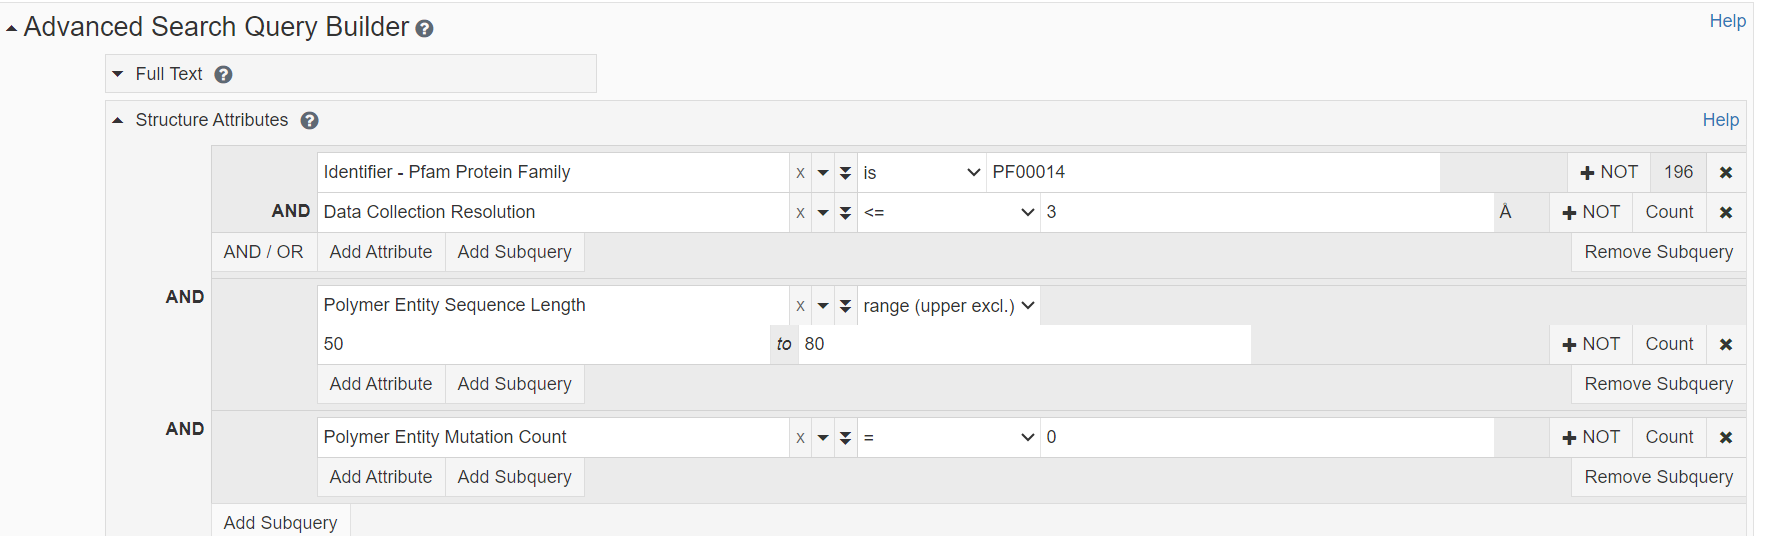






We need to reomve the redunduncy to make out data balanced, by clustering the seqs and choose a representative of the cluster.

We choose an identity of 50% as a threshold


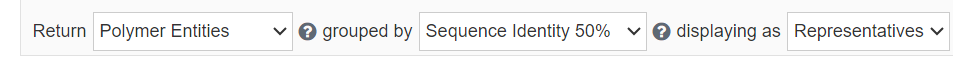



We got this report where empty lines represent: same sequence with multiple chains

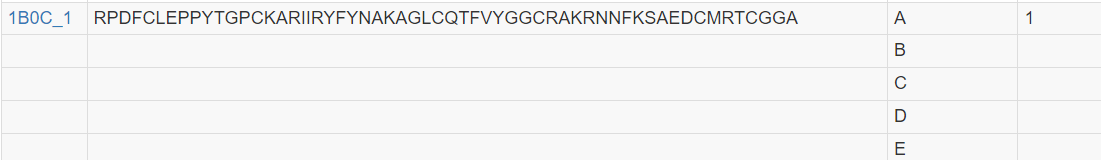

Downloading the  pdb report:

In [1]:
!wget -q -O training.csv https://github.com/aliyhassan1/Lab1-Project/blob/main/training.csv?raw=true

In [2]:
! head -n 4 training.csv

Identifier,StructureData,Polymer EntityData,,
Entity ID,PDB ID,Sequence,Auth Asym ID,
"1AAP_1","1AAP","VREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSA","A"
,,,"B"


We use 'tr' coommand to delete  double quotes, awk for choosing the pdb ids with chains and then we remove the first three lines  and finally save the ids into a text file called id_list.txt.

In [3]:
! cat training.csv| tr -d '""' | awk -F "," '{ if ($1 != "") {print $2":" $4}}'|tail -n +3 > id_list.txt

In [73]:
!cat id_list.txt | wc

     21      21     147


##Protein alignment

We go to pdbefold to do like-blast structure alignment:


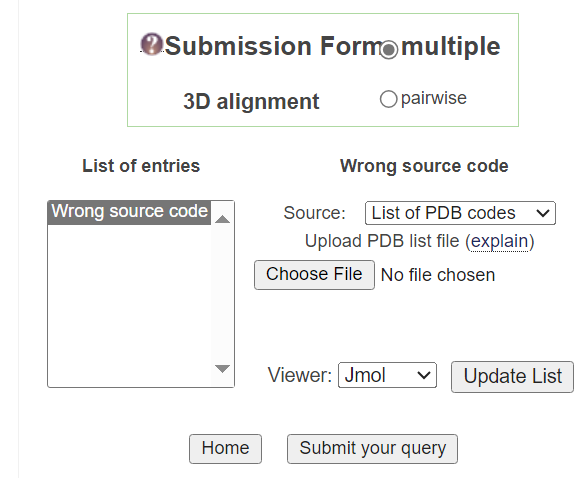

We get this fasta file:

In [5]:
! wget -q -O pdbe.fasta  https://github.com/aliyhassan1/Lab1-Project/blob/main/pdbe.fasta?raw=true

In [6]:
! head -n 5 pdbe.fasta

>PDB:1aap:A X-RAY CRYSTAL STRUCTURE OF THE PROTEASE INHIBITOR 
--------------------vrevcseqaetgpcrAmISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEY
CMAVCg---

>PDB:1bun:B STRUCTURE OF BETA2-BUNGAROTOXIN: POTASSIUM CHANNEL


We parse the alignment file, getting the pdb ids with the sequences (we remove the first 20 positions from the alignment as most of them are gaps).

In [7]:
! cat /content/pdbe.fasta | awk '{if(substr($0,1,1)== ">") {print $1} else {print toupper(substr($0,20,59))}}' > mogaps_3dalign.ali

In [84]:
! cat mogaps_3dalign.ali

>PDB:1aap:A
-VREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEY


>PDB:1bun:B
KRHPDCDKPPDTKICQTVVRAFYYKPSAKRCVQFRYGGCNGNGNHFKSDHL


>PDB:1dtx:A
PRRKLCILHRNPGRCYDKIPAFYYNQKKKQCERFDWSGCGGNSNRFKTIEE


>PDB:1fak:I
-APDFCLEPPYDGPCRALHLRYFYNAKAGLCQTFYYGGCLAKRNNFESAED


>PDB:1kth:A
ETDICKLPKDEGTCRDF-ILKWYYDPNTKSCARFWYGGCGGNENKFGSQKE


>PDB:1yc0:I
QTEDYCLASNKVGRCRGSFPRWYYDPTEQICKSFVYGGCLGNKNNYLREEE


>PDB:1zr0:B
NNAEICLLPLDYGPCRALLLRYYYDRYTQSCRQFLYGGCEGNANNFYTWEA


>PDB:3byb:A
DRPDFCELPADTGPCRVRFPSFYYNPDEKKCLEFIYGGCEGNANNFITKEE


>PDB:3m7q:B
AEASICSEPKKVGRCKGYFPRFYFDSETGKCTPFIYGGCGGNGNNFETLHQ


>PDB:4bqd:A
LMHSFCAFKADDGPCKAIMKRFFFNIFTRQCEEFIYGGCEGNQNRFESLEE


>PDB:4dtg:K
EKPDFCFLEEDPGICRGYITRYFYNNQTKQCERFKYGGCLGNMNNFETLEE


>PDB:4iso:B
QTEDYCLASNKVGRCRGSFPRWYYDPTEQICKSFVYGGCLGNKNNYLREEE


>PDB:4ntw:B
RPAFCYEDPPFFQKCGAFVDSYYFNRSRITCVHFFYGQCDVNQNHFTTMSE


>PDB:4u30:X
---ACANLPIVRGPCRAFIQLWAFDAVKGKCVLFPYGGCQGNGNKFYSEKE


>PDB:4u32:X
--HDFCLVSKVVGRCRASMPRWWYNVTDGSCQLFVYGGCDGNSNNYLTKEE


>PDB:5m4v:

We notice that PDB:5nx1:D is too short compared to other proteins so we'll delete it

In [22]:
! cat nogaps_3dalign.ali | grep -n ">PDB:5nx1:D"

65:>PDB:5nx1:D


In [25]:
! sed '65,68d' nogaps_3dalign.ali > fin_3dalign.ali

##Modeling the Kunitz-domain with an HMM

Installing HMMER:

In [26]:
! apt-get install hmmer &> /dev/null
! apt-get install hmmer-doc &> /dev/null

In [27]:
! hmmbuild nogaps_3d_align.hmm fin_3dalign.ali &> /dev/null

We get this logo:

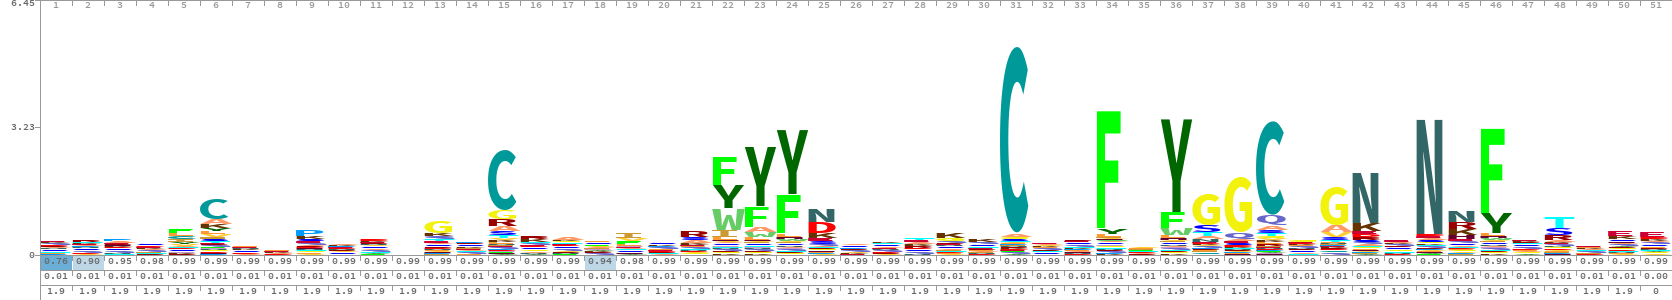

##Building the training and benchmark sets

Downloading the negative dataset:

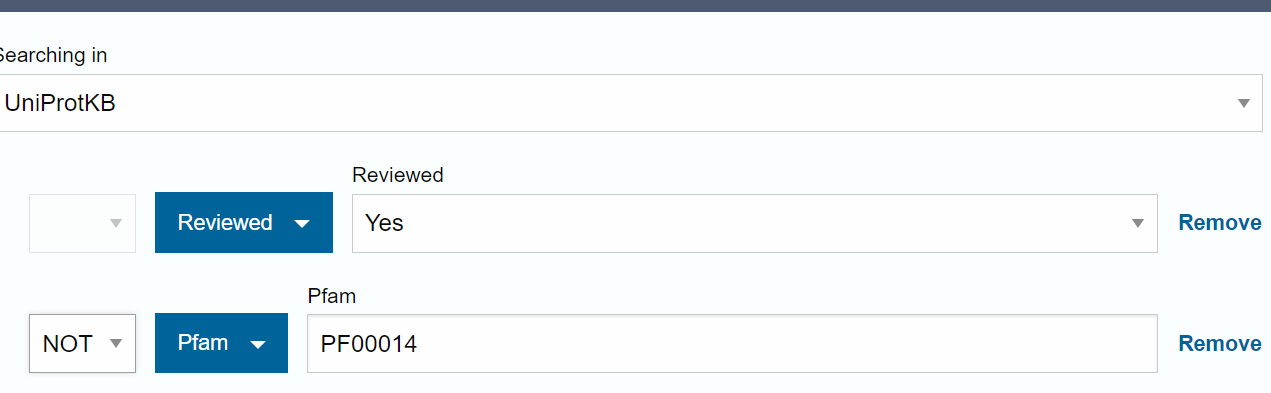

In [28]:
! wget -q -O negative.fasta.gz 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query=%28%28reviewed%3Atrue%29+NOT+%28xref%3Apfam-PF00014%29%29'

In [29]:
! gunzip -d /content/negative.fasta.gz &> /dev/null

Downloading the positive:

In [30]:
! wget -q -O positive.fasta.gz "https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query=%28%28reviewed%3Atrue%29+AND+%28xref%3Apfam-PF00014%29%29"

In [31]:
! gunzip positive.fasta.gz

The positive set includes proteins from the HMM training set which we have to remove.

We also have to remove the sequences that are 97 % similar to these sequences.

We use Blast to achieve this goal.

In [32]:
! wget -q https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.15.0+-x64-linux.tar.gz

In [33]:
! ! tar -zxvf /content/ncbi-blast-2.15.0+-x64-linux.tar.gz &> /dev/null

Building our blast-dataset from the positive proteins:

In [34]:
! /content/ncbi-blast-2.15.0+/bin/makeblastdb -in /content/positive.fasta  -dbtype prot



Building a new DB, current time: 05/20/2024 18:09:24
New DB name:   /content/positive.fasta
New DB title:  /content/positive.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 391 sequences in 0.0123889 seconds.




Preparing the HMM training set as a fasta file so we can query them on the positive dataset:

In [35]:
! cat training.csv| tr -d '""' | awk -F "," '{ if ($1 != "") {print ">"$1, "\n" ,$3}}'| tail -n +5 > training.fasta

In [36]:
! /content/ncbi-blast-2.15.0+/bin/blastp -query training.fasta -db /content/positive.fasta  -out remove.blast -outfmt 7

In [37]:
! cat  remove.blast | grep -v '^#'| tail -n +6 | sort -rnk 3| awk '{if ($3 > 97) {print $0}}'| head -n 5

5YV7_1	sp|P81658|VKTHC_DENAN	100.000	60	0	0	1	60	1	60	1.26e-41	123
5PTI_1	sp|P00974|BPT1_BOVIN	100.000	58	0	0	1	58	36	93	1.05e-41	124
5NX1_3	sp|P08592|A4_RAT	100.000	42	0	0	1	42	302	343	2.69e-30	103
4U32_1	sp|O43291|SPIT2_HUMAN	100.000	55	0	0	1	55	34	88	4.43e-39	122
4NTW_2	sp|G9I929|VKTA_MICTN	100.000	60	0	0	1	60	25	84	2.14e-44	130


In [38]:
! cat  remove.blast | grep -v "^#" | sort -rnk 3| awk '{if ($3 > 97) {print $2}}'|cut -d "|" -f 2 |sort -u > remove-ids.txt

The number of ids we have to remove:

In [39]:
! cat remove-ids.txt| wc

     27      27     189


The total number of proteins in the positive dataset:

In [40]:
! cat positive.fasta| grep -c ">"

391


Removing the ids:

In [41]:
def filter_sequences(seq_file_path, ids_file_path, output_file_path):
    with open(ids_file_path, 'r') as file:
        excluded_ids = {line.strip() for line in file}

    with open(seq_file_path, 'r') as file:
        content = file.read().strip()
        sequences = content.split('>')
        sequences = sequences[1:]

    with open(output_file_path, 'w') as outfile:
        for sequence in sequences:
            header = sequence.split('\n', 1)[0]
            seq_id = header.split('|')[1]

            if seq_id not in excluded_ids:
                outfile.write(f'>{sequence}')

filter_sequences("/content/positive.fasta", "/content/remove-ids.txt", "/content/positive_wo_training")

The number of remaining sequences, which contain kunitz domain but at least 3% different from the training set:

In [42]:
! cat positive_wo_training| grep -c ">"

364


Shuffling each of the positive and negative files and then splitting each into two sets:

In [43]:
def read_fasta(file_path):

    sequences = []
    with open(file_path, "r") as fasta_file:
        header = ""
        sequence = ""
        for line in fasta_file:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences.append((header, sequence))
                header = line
                sequence = ""
            else:
                sequence += line
        if header:
            sequences.append((header, sequence))
    return sequences

def shuffle_sequences(sequences):

    import random
    shuffled_sequences = list(sequences)
    random.shuffle(shuffled_sequences)
    return shuffled_sequences

def shuffle_divide_write(fastafile, sh_fastafile1,sh_fastafile2 ):
    lst  = shuffle_sequences(read_fasta(fastafile))
    n = len(lst)
    hlf1 = lst[:n//2]
    hlf2 = lst[n//2:]
    sh1 = open(sh_fastafile1, 'w')
    for header ,seq in hlf1:
      sh1.write(header+"\n")
      for i in range(0,len(seq),60):
        sh1.write(seq[i:i+60]+ "\n")
    sh2 = open(sh_fastafile2, 'w')
    for header ,seq in hlf2:
      sh2.write(header+"\n")
      for i in range(0,len(seq),60):
        sh2.write(seq[i:i+60]+ "\n")



shuffle_divide_write("/content/positive_wo_training", "pos1.txt", "pos2.txt")
shuffle_divide_write("/content/negative.fasta", "neg1.txt", "neg2.txt")


Let's do hmmsearch on each of the resulting datasets:


we are trying to maximize the number of results

we use --max to turn off the heuristic approach

we use -Z to make search consistent



On positive 1:

In [44]:
! hmmsearch --domZ 1 -Z 100 --max --noali --tblout pos1se.txt nogaps_3d_align.hmm pos1.txt &> /dev/null

On positive 2:

In [45]:
! hmmsearch --domZ 1 -Z 100 --max --noali --tblout pos2se.txt nogaps_3d_align.hmm pos2.txt &> /dev/null

In [46]:
! cat pos1se.txt | grep -c "sp"
! cat pos2se.txt | grep -c "sp"

182
182


The numbers above show that we haven't lost any of the positive dataset sequences

On negative 1:

In [47]:
! hmmsearch --domZ 1 -Z 100 --max --noali --tblout neg1se.txt nogaps_3d_align.hmm neg1.txt &> /dev/null

On negative 2:

In [48]:
! hmmsearch --domZ 1 -Z 100 --max --noali --tblout neg2se.txt nogaps_3d_align.hmm neg2.txt &> /dev/null

In [49]:
! cat neg1se.txt | grep -c "sp"
! cat neg1.txt | grep -c "sp"

37958
285445


In [50]:
! cat neg2se.txt | grep -c "sp"
! cat neg2.txt | grep -c "sp"

38320
285446


The reported fraction of negative sequences is low so we need to recover the missing sequences.

We parse the hmmsearch files retrieving ids, e-values and class numbers (1 if positive or 0 if negative).

In [51]:
! grep -v "^#" pos1se.txt | awk '{print $1"\t"$8"\t1"}' > pos1ev.txt

In [52]:
! grep -v "^#" pos2se.txt | awk '{print $1"\t"$8"\t1"}' > pos2ev.txt

In [53]:
! grep -v "^#" neg1se.txt | awk '{print $1"\t"$8"\t0"}' > neg1ev.txt

In [54]:
! grep -v "^#" neg2se.txt | awk '{print $1"\t"$8"\t0"}' > neg2ev.txt

Then we use python to retrieve non-reported negative sequences.

In [55]:
def retrieve_non_reported_negative(reported_file , allfile, outputfile):
  ref = open(reported_file, 'r')
  reported_seqs = {}
  for line in ref:
    line = line.strip()
    id = line.split()[0]
    reported_seqs[id] = "0"
  allf = open(allfile, 'r')
  outf = open(outputfile, 'w')
  for line in allf:
    line = line.strip()
    if line.startswith('>') == False: continue
    id = line.split()[0][1:]
    if id in reported_seqs: continue
    outf.write("%s\t10\t0\n" % id)



retrieve_non_reported_negative("neg1ev.txt" , "neg1.txt", "neg1mis.txt")
retrieve_non_reported_negative("neg2ev.txt" , "neg2.txt", "neg2mis.txt")



Rebuilding the negative files again:

In [56]:
! cat neg1mis.txt neg1ev.txt > neg1fin.txt

In [57]:
! cat neg2mis.txt neg2ev.txt > neg2fin.txt

Now we have the 4 files ready for statistical analysis:

pos1ev.txt

pos2ev.txt

neg1fin.txt

neg2fin.txt

We merge the files in a way we get two files each contains half of the positives and half of the negatives.

In [58]:
! cat neg1fin.txt pos1ev.txt > posneg1.txt
! cat neg2fin.txt pos2ev.txt > posneg2.txt

##Performance evaluation

We apply the performance python script:

In [59]:
%%writefile performance.py

#!/usr/bin/python
import sys, math
import numpy as np

def get_blast(filename):
  '''returns a list of sorted (e-values, 0\1s)'''
  flist=[]
  d={}
  f=open(filename)
  for line in f:
    v=line.rstrip().split()
    d[v[0]]=d.get(v[0],[])
    d[v[0]].append([float(v[1]),int(v[2])])
  for v in d.values():
    v.sort()
    flist.append(v[0])
  return flist


def get_cm(data,th):
  # CM=[[TP,FP],[FN,TN]]
  # 0 = Negatives 1=Positives
  cm=[[0.0,0.0],[0.0,0.0]]
  for i in data:
    if i[0]<th and i[1]==1:
      cm[0][0]=cm[0][0]+1
    if i[0]>=th and i[1]==1:
      cm[1][0]=cm[1][0]+1
    if i[0]<th and i[1]==0:
      cm[0][1]=cm[0][1]+1
    if i[0]>th and i[1]==0:
      cm[1][1]=cm[1][1]+1
  return cm


def get_acc(cm):
  return float(cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))


def mcc(m):
  d=(m[0][0]+m[1][0])*(m[0][0]+m[0][1])*(m[1][1]+m[1][0])*(m[1][1]+m[0][1])
  return (m[0][0]*m[1][1]-m[0][1]*m[1][0])/math.sqrt(d)



if __name__ == "__main__":
  filename=sys.argv[1]
  #th=float(sys.argv[2])
  data=get_blast(filename)
  for i in range(1, 16):
    th=10**-i
    cm=get_cm(data,th)
    print ('TH:',th,'Q2:',get_acc(cm),'MCC:',mcc(cm),'N= ', np.sum(cm),\
           'TP= ', cm[0][0], 'TN= ', cm[1][1],'FP= ', cm[0][1], 'FN= ', cm[1][0] )


Writing performance.py


In [60]:
! python3 performance.py posneg1.txt > per1.res

In [61]:
! python3 performance.py posneg2.txt > per2.res

In [62]:
! cat per1.res| sort -nrk 6

TH: 1e-06 Q2: 0.9999929978608465 MCC: 0.9945019912036325 N=  285627.0 TP=  181.0 TN=  285444.0 FP=  1.0 FN=  1.0
TH: 1e-05 Q2: 0.9999929978608465 MCC: 0.9945019912036325 N=  285627.0 TP=  181.0 TN=  285444.0 FP=  1.0 FN=  1.0
TH: 1e-09 Q2: 0.9999929978608465 MCC: 0.9944868322162255 N=  285627.0 TP=  180.0 TN=  285445.0 FP=  0.0 FN=  2.0
TH: 1e-08 Q2: 0.9999929978608465 MCC: 0.9944868322162255 N=  285627.0 TP=  180.0 TN=  285445.0 FP=  0.0 FN=  2.0
TH: 1e-07 Q2: 0.9999929978608465 MCC: 0.9944868322162255 N=  285627.0 TP=  180.0 TN=  285445.0 FP=  0.0 FN=  2.0
TH: 0.0001 Q2: 0.9999894967912697 MCC: 0.991779293960006 N=  285627.0 TP=  181.0 TN=  285443.0 FP=  2.0 FN=  1.0
TH: 1e-10 Q2: 0.9999824946521162 MCC: 0.9861594381941183 N=  285627.0 TP=  177.0 TN=  285445.0 FP=  0.0 FN=  5.0
TH: 1e-11 Q2: 0.9999789935825395 MCC: 0.983368008738265 N=  285627.0 TP=  176.0 TN=  285445.0 FP=  0.0 FN=  6.0
TH: 1e-12 Q2: 0.999971991443386 MCC: 0.9777613012951153 N=  285627.0 TP=  174.0 TN=  285445.0 FP=

The best is around 1e-6

In [74]:
!  cat per2.res | grep '1e-06'

TH: 1e-06 Q2: 0.9999894968280421 MCC: 0.9917187842306645 N=  285628.0 TP=  179.0 TN=  285446.0 FP=  0.0 FN=  3.0


In [64]:
! cat per2.res| sort -nrk 6

TH: 1e-08 Q2: 0.9999894968280421 MCC: 0.9917187842306645 N=  285628.0 TP=  179.0 TN=  285446.0 FP=  0.0 FN=  3.0
TH: 1e-07 Q2: 0.9999894968280421 MCC: 0.9917187842306645 N=  285628.0 TP=  179.0 TN=  285446.0 FP=  0.0 FN=  3.0
TH: 1e-06 Q2: 0.9999894968280421 MCC: 0.9917187842306645 N=  285628.0 TP=  179.0 TN=  285446.0 FP=  0.0 FN=  3.0
TH: 1e-05 Q2: 0.9999894968280421 MCC: 0.9917187842306645 N=  285628.0 TP=  179.0 TN=  285446.0 FP=  0.0 FN=  3.0
TH: 0.0001 Q2: 0.9999859957707228 MCC: 0.9890039824318112 N=  285628.0 TP=  180.0 TN=  285444.0 FP=  2.0 FN=  2.0
TH: 1e-11 Q2: 0.9999859957707228 MCC: 0.9889430079823481 N=  285628.0 TP=  178.0 TN=  285446.0 FP=  0.0 FN=  4.0
TH: 1e-10 Q2: 0.9999859957707228 MCC: 0.9889430079823481 N=  285628.0 TP=  178.0 TN=  285446.0 FP=  0.0 FN=  4.0
TH: 1e-09 Q2: 0.9999859957707228 MCC: 0.9889430079823481 N=  285628.0 TP=  178.0 TN=  285446.0 FP=  0.0 FN=  4.0
TH: 1e-12 Q2: 0.9999789936560841 MCC: 0.9833680087744711 N=  285628.0 TP=  176.0 TN=  285446.0 

The optimal e-value is around 1e-08

In [75]:
! cat per1.res | grep '1e-08'

TH: 1e-08 Q2: 0.9999929978608465 MCC: 0.9944868322162255 N=  285627.0 TP=  180.0 TN=  285445.0 FP=  0.0 FN=  2.0


Let's create the confusion matrix for the whole dataset with 1e-07

In [67]:
! python3 performance.py <(cat  posneg1.txt posneg2.txt) > roc.data

In [85]:
! cat roc.data| grep "1e-08"

TH: 1e-08 Q2: 0.9999912473413799 MCC: 0.9931037702101227 N=  571255.0 TP=  359.0 TN=  570891.0 FP=  0.0 FN=  5.0


To know which proteins are false negatives we can search in the positives file for the proteins associated with the highest e-value

In [86]:
! cat pos2ev.txt pos1ev.txt | sort -grk 2 | head -n 5| cut -d "|" -f 2

D3GGZ8
O62247
Q8WPG5
Q11101
P86963


Let's draw the ROC curve:


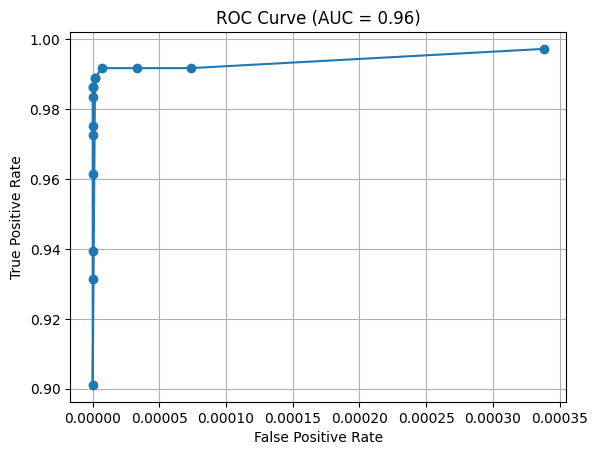

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps

# Function to parse data from file
def parse_or_roc(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # Check if the line is not empty
                entry = {}
                parts = line.strip().split()
                entry["TH"] = float(parts[1])
                entry["Q2"] = float(parts[3])
                entry["MCC"] = float(parts[5])
                entry["N"] = float(parts[7])
                entry["TP"] = float(parts[9])
                entry["TN"] = float(parts[11])
                entry["FP"] = float(parts[13])
                entry["FN"] = float(parts[15])
                data.append(entry)
    return data

# Read data from file
file_path = 'roc.data'
data = parse_or_roc(file_path)

# Extract TP, FP, TN, FN
TP = [entry["TP"] for entry in data]
FP = [entry["FP"] for entry in data]
TN = [entry["TN"] for entry in data]
FN = [entry["FN"] for entry in data]

# Calculate TPR (True Positive Rate) and FPR (False Positive Rate)
TPR = np.array(TP) / (np.array(TP) + np.array(FN))
FPR = np.array(FP) / (np.array(FP) + np.array(TN))

# Sort the points by increasing FPR
sorted_indices = np.argsort(FPR)
FPR = FPR[sorted_indices]
TPR = TPR[sorted_indices]

# Calculate AUC using Simpson's rule
auc = simps(TPR, FPR)/ 0.00035

# Plot ROC Curve
plt.plot(FPR, TPR, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
plt.grid(True)
plt.show()
